In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [3]:
select_cols = [
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold'
]
target_cols = ['SalePrice']
df = df[select_cols + target_cols]

In [4]:
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

In [5]:
NULL_TARGET = 13 # GrLivArea

In [6]:
def agg_null_hist(df, types):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].hist(x='GrLivArea', data=X, label='Not Null', range=(X['GrLivArea'].min(), X['GrLivArea'].max()))
    axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
    # axes[1].hist(x='GrLivArea', data=df[df['GrLivArea'].notnull()], label='Not Null', range=(X['GrLivArea'].min(), X['GrLivArea'].max()))
    # axes[1].hist(x='GrLivArea', data=X[df['GrLivArea'].isnull()], label='Null', range=(X['GrLivArea'].min(), X['GrLivArea'].max()))
    axes[1].hist([df[df['GrLivArea'].notnull()]['GrLivArea'], X[df['GrLivArea'].isnull()]['GrLivArea']], stacked=True)
    axes[1].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)

    axes[0].set(title='ALL')
    axes[1].set(title=f'{types}')

    axes[0].set(xlabel="GrLivArea")
    axes[1].set(xlabel="GrLivArea")
    fig.show()

In [7]:
def eval_simple_impute(df, types, scores):
    for strategy in ('mean', 'median'):
        imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
        trans = imputer.fit_transform(df)
        trans_df = pd.DataFrame(trans)
        trans_df.columns = select_cols
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].hist(x='GrLivArea', data=X, label='BASE', range=(X['GrLivArea'].min(), X['GrLivArea'].max()), alpha=0.5)
        axes[0].hist(x='GrLivArea', data=trans_df, label='IMPUTE', range=(X['GrLivArea'].min(), X['GrLivArea'].max()), alpha=0.5)
        axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
        axes[0].set(title=f'{types} / {strategy}')
        axes[0].set(xlabel="GrLivArea")

        impute_df = pd.concat([X['GrLivArea'], trans_df['GrLivArea']], axis=1)
        impute_df.columns = ["GrLivArea_base", "GrLivArea_impute"]
        axes[1].scatter(x='GrLivArea_base', y='GrLivArea_impute', data=impute_df.iloc[idx, :])
        axes[1].set(title=f"MCAR / {strategy}")
        axes[1].set(xlabel="GrLivArea_BASE")
        axes[1].set(ylabel="GrLivArea_IMPUTE")
        
        scores.append(mean_squared_error(np.log1p(impute_df['GrLivArea_base']), np.log1p(impute_df['GrLivArea_impute'])))
        fig.show()
        
    return scores

In [8]:
def eval_iter_impute(df, types, scores):
    estimators = {
        "BayesianRidge": BayesianRidge(),
        "DecisionTree":DecisionTreeRegressor(max_features='sqrt', random_state=1234),
        "ExtraTrees":ExtraTreesRegressor(n_estimators=10, random_state=1234),
        "KNeighbors":KNeighborsRegressor(n_neighbors=15)
    }
    score_iterative_imputer = pd.DataFrame()
    for method, impute_estimator in estimators.items():
        imputer = IterativeImputer(random_state=1234, estimator=impute_estimator)
        trans = imputer.fit_transform(df)
        trans_df = pd.DataFrame(trans)
        trans_df.columns = select_cols
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].hist(x='GrLivArea', data=X, label='BASE', range=(X['GrLivArea'].min(), X['GrLivArea'].max()), alpha=0.5)
        axes[0].hist(x='GrLivArea', data=trans_df, label='IMPUTE', range=(X['GrLivArea'].min(), X['GrLivArea'].max()), alpha=0.5)
        axes[0].legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
        axes[0].set(title=f'{types} / {method}')
        axes[0].set(xlabel="GrLivArea")

        impute_df = pd.concat([X['GrLivArea'], trans_df['GrLivArea']], axis=1)
        impute_df.columns = ["GrLivArea_base", "GrLivArea_impute"]
        axes[1].scatter(x='GrLivArea_base', y='GrLivArea_impute', data=impute_df.iloc[idx, :])
        axes[1].set(title=f'{types} / {method}')
        axes[1].set(xlabel="GrLivArea_BASE")
        axes[1].set(ylabel="GrLivArea_IMPUTE")
        
        scores.append(mean_squared_error(np.log1p(impute_df['GrLivArea_base']), np.log1p(impute_df['GrLivArea_impute']).fillna(1)))

        fig.show()
    return scores

In [9]:
# MCAR
X_mcar = X.copy()
idx = X.sample(frac=0.3, random_state=1234).index
X_mcar.iloc[idx, NULL_TARGET] = np.nan
mcar_score = []

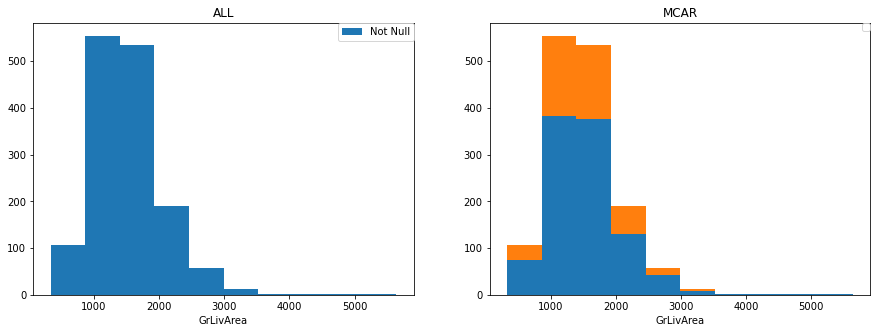

In [10]:
agg_null_hist(X_mcar, "MCAR")

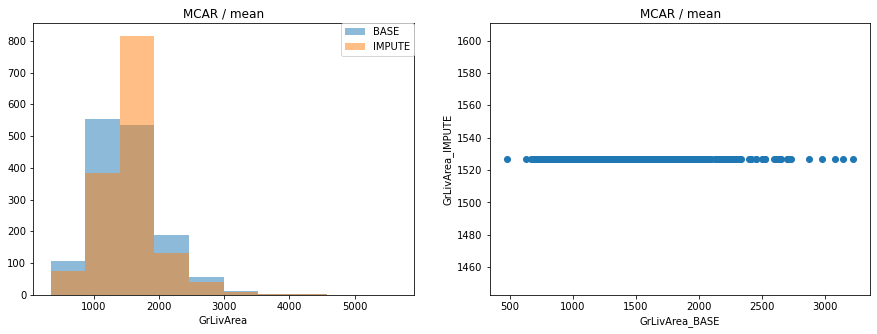

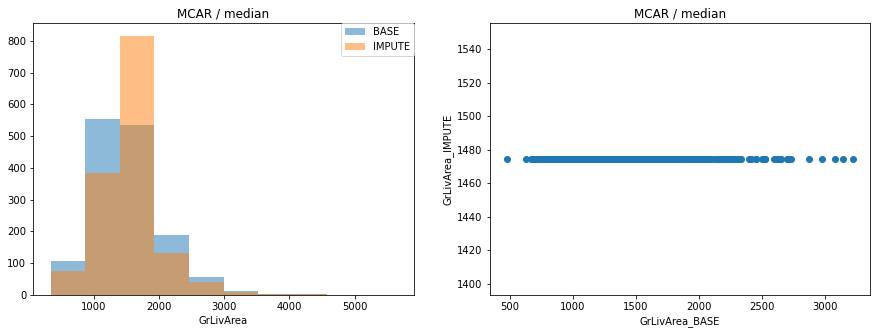

In [11]:
mcar_score = eval_simple_impute(X_mcar, "MCAR", mcar_score)

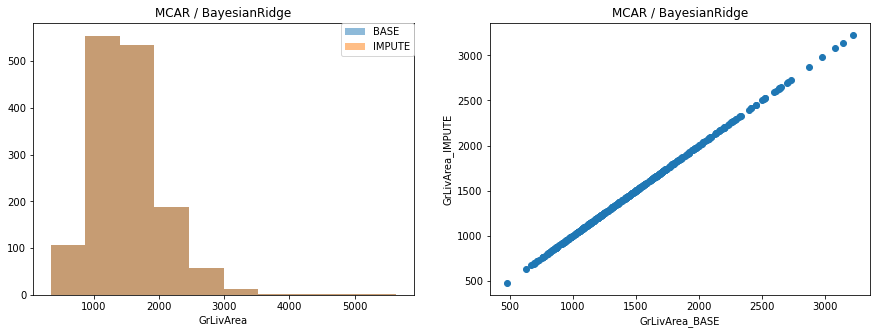

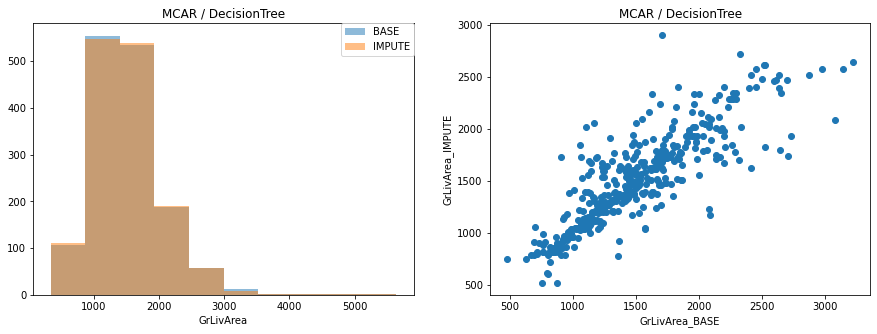

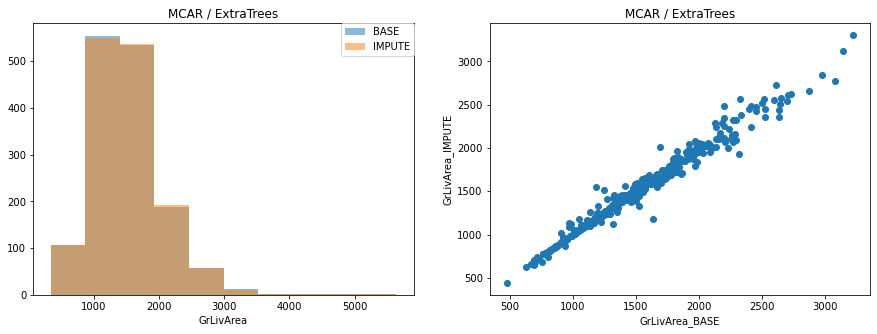

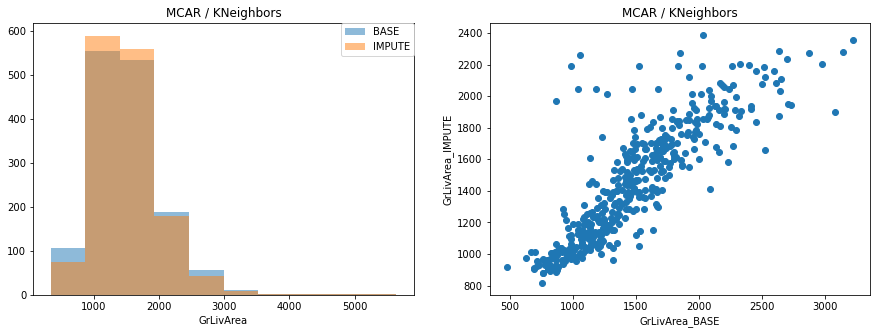

In [12]:
mcar_score = eval_iter_impute(X_mcar, "MCAR", mcar_score)

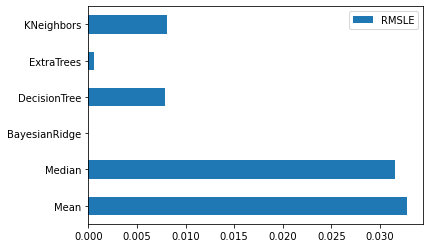

In [13]:
score_mcar_df = pd.DataFrame(mcar_score)
score_mcar_df.index = [
    "Mean",
    "Median",
    "BayesianRidge",
    "DecisionTree",
    "ExtraTrees",
    "KNeighbors"
]
score_mcar_df.columns = ["RMSLE"]
score_mcar_df.plot.barh()

In [14]:
# MAR
X_mar = X.copy()
idx = X[X['YearBuilt'] < 1945].sample(frac=0.7, random_state=1234).index
X_mar.iloc[idx, NULL_TARGET] = np.nan
mar_score = []

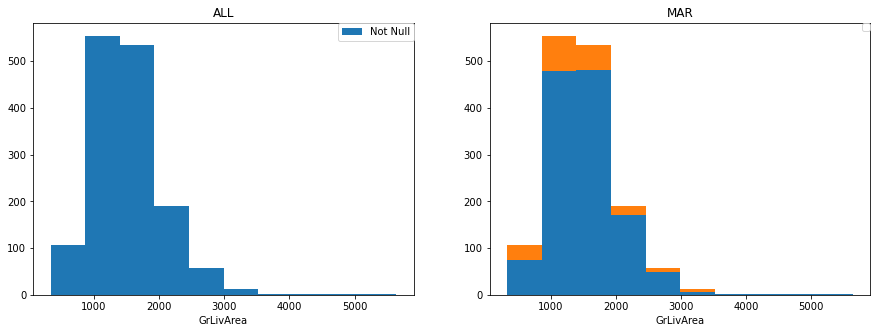

In [15]:
agg_null_hist(X_mar, "MAR")

[0.02294974440658783, 0.022063513476911722]

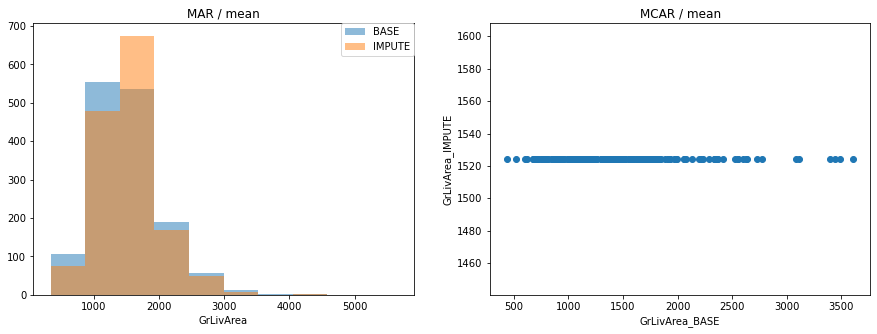

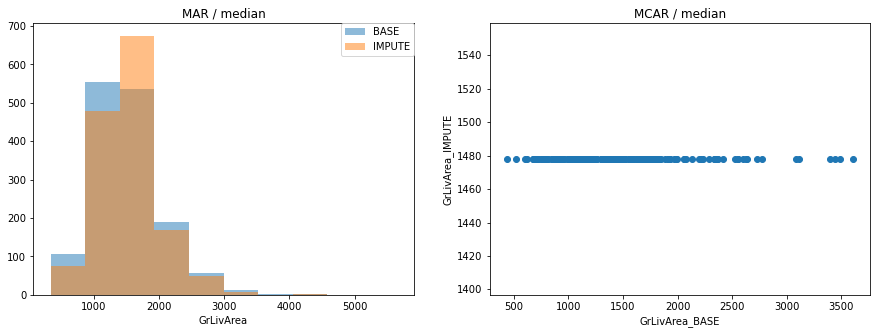

In [16]:
eval_simple_impute(X_mar, "MAR", mar_score)

[0.02294974440658783,
 0.022063513476911722,
 2.564991327771517e-10,
 0.005188732675430153,
 0.0005995437316892237,
 0.006209651166777869]

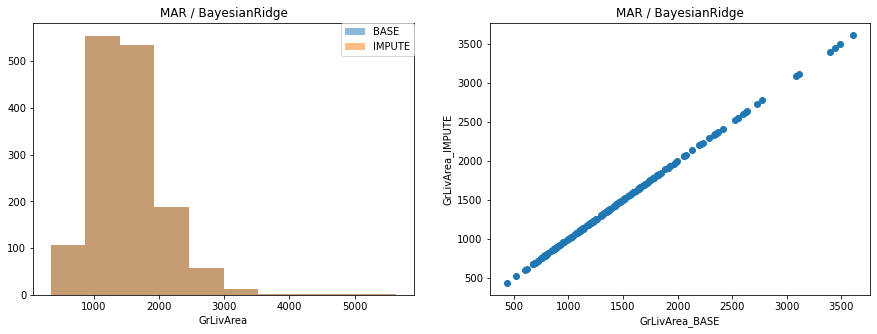

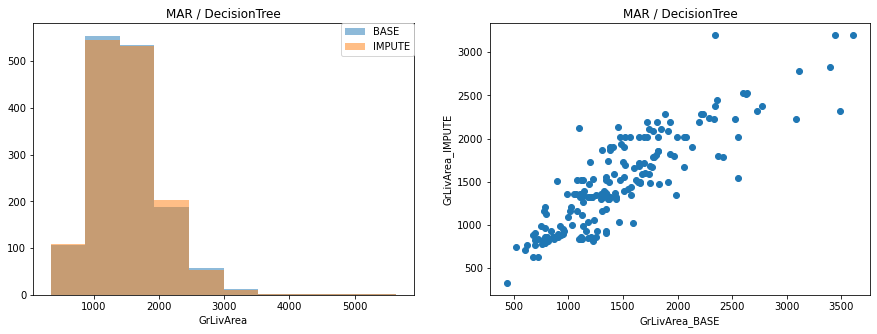

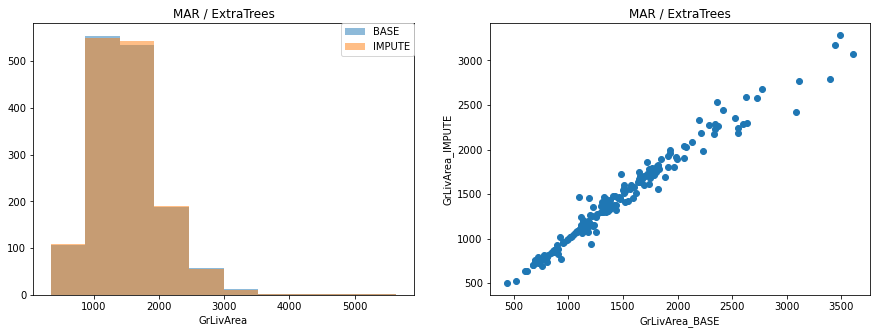

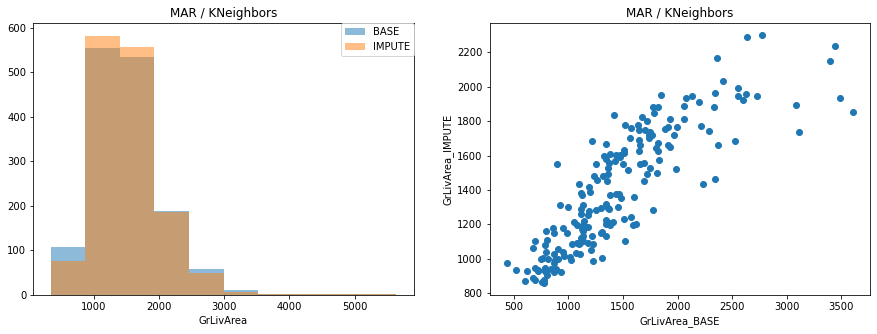

In [17]:
eval_iter_impute(X_mar, "MAR", mar_score)

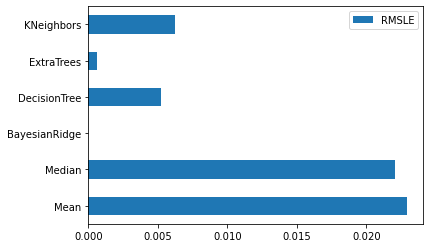

In [18]:
score_mar_df = pd.DataFrame(mar_score)
score_mar_df.index = [
    "Mean",
    "Median",
    "BayesianRidge",
    "DecisionTree",
    "ExtraTrees",
    "KNeighbors"
]
score_mar_df.columns = ["RMSLE"]
score_mar_df.plot.barh()

In [19]:
# MNAR
X_mnar = X.copy()
idx = X[X['GrLivArea'] < 1000].sample(frac=0.7, random_state=1234).index
X_mnar.iloc[idx, NULL_TARGET] = np.nan
mnar_score = []

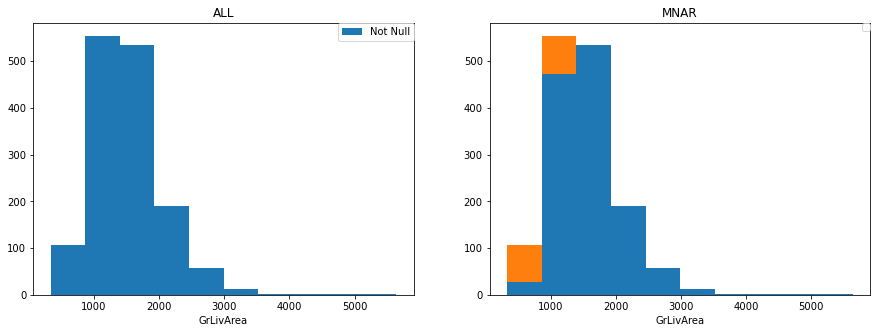

In [20]:
agg_null_hist(X_mnar, "MNAR")

[0.04398872830229238, 0.037476687150095646]

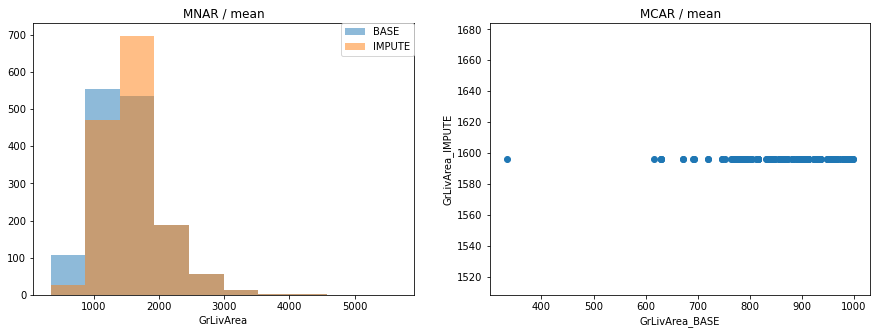

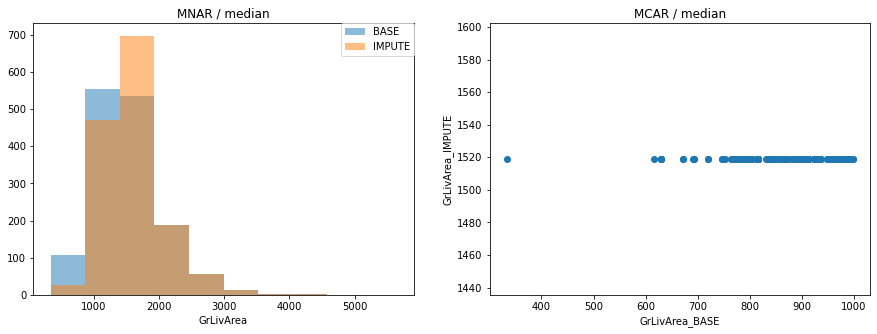

In [21]:
eval_simple_impute(X_mnar, "MNAR", mnar_score)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


[0.04398872830229238,
 0.037476687150095646,
 0.02139816932645558,
 0.005372795527893296,
 0.00034936444148415545,
 0.010069016647290166]

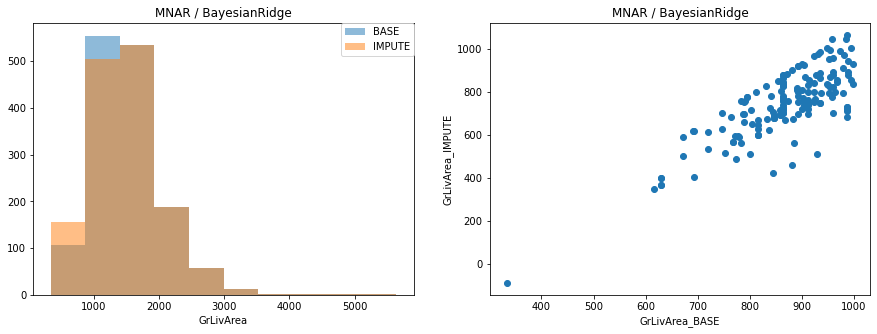

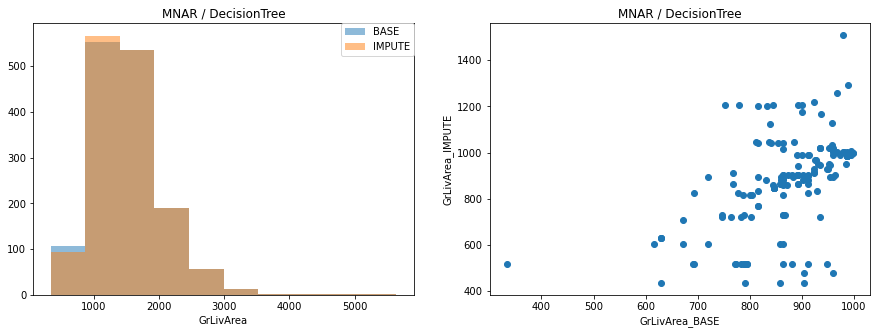

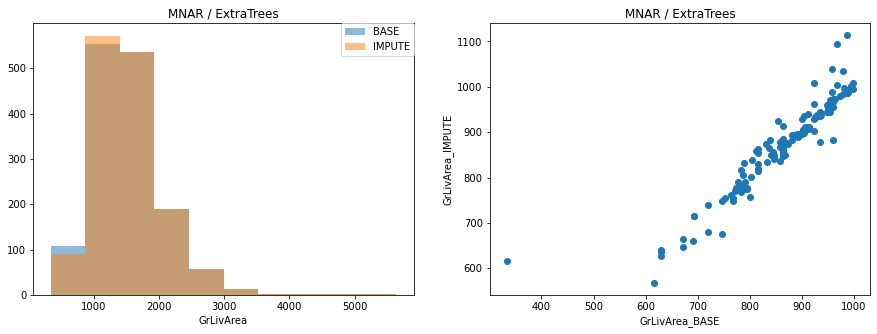

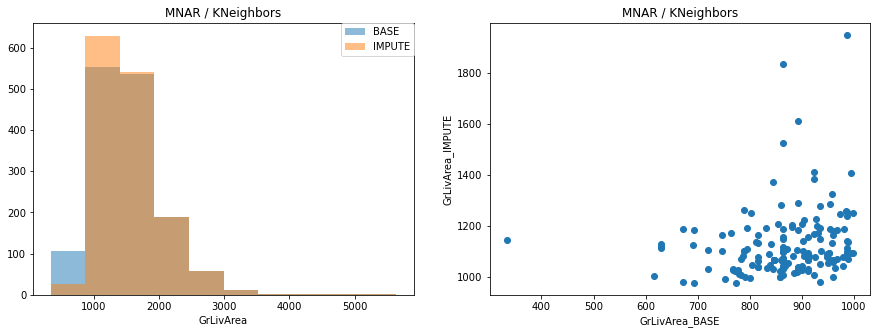

In [22]:
eval_iter_impute(X_mnar, "MNAR", mnar_score)

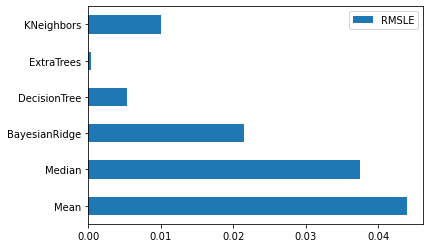

In [23]:
score_mnar_df = pd.DataFrame(mnar_score)
score_mnar_df.index = [
    "Mean",
    "Median",
    "BayesianRidge",
    "DecisionTree",
    "ExtraTrees",
    "KNeighbors"
]
score_mnar_df.columns = ["RMSLE"]
score_mnar_df.plot.barh()